# ABS Inflation model

Aim: to forecasr the next trimmed mean (TM) print based on ...
- upstream inflation PPI
- prevaiing cost pressures WPI
- the Phillips curve (inflation and unemployment have an inverse relationship) UER)
- previous quarter TM, as the series is autocorrelated. 

## Python set-up

In [1]:
# system imports
from pathlib import Path
from typing import Sequence, cast
from math import isfinite

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
# local imports
from abs_data_capture import (
    AbsLandingPage,
    AbsMultiSeries,
    AbsSelectInput,
    AbsSelectionDict,
    get_multi_series,
)
from plotting import line_plot, finalise_plot, set_chart_dir, clear_chart_dir
from henderson import hma

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/Inflation-Model/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# Uaeful markers
QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}


# display charts in this notebook
SHOW = True

## Data capture

 ### Identify the data we want to use

In [4]:
q_wanted: AbsSelectionDict = {
    "Qrtly CPI Trimmed Mean": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="consumer-price-index-australia",
        ),
        table="8",
        orig_sa="SA",
        search1="Percentage Change from Previous Period",
        search2="Trimmed Mean ;  Australia",
        abbr="TM",
        calc_growth=False,
    ),
    "Producer Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="producer-price-indexes-australia",
        ),
        table="1",
        orig_sa="Orig",
        search1="Percentage change from previous quarter",
        search2="Final ;  Total ",
        abbr="PPI",
        calc_growth=False,
    ),
    "Wage Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="wage-price-index-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Percentage Change From Previous Quarter",
        search2="Australia ;  Total hourly rates of pay excluding bonuses ;  Private and Public",
        abbr="WPI",
        calc_growth=False,
    ),
}

m_wanted: AbsSelectionDict = {
    "Unemployment Rate": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="labour",
            parent_topic="employment-and-unemployment",
            topic="labour-force-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Unemployment rate ;",
        search2="Persons",
        abbr="UER",
        calc_growth=False,
    ),
}

### Collect and marshall that data

In [12]:
def collect_data(
    q_wanted: AbsSelectionDict, m_wanted: AbsSelectionDict
) -> tuple[pd.DataFrame, pd.Index, pd.Series]:
    """Collect the data for the inflation model."""

    # get the quarterly data ...
    q_dataset = get_multi_series(q_wanted, verbose=False)
    fug = {q_dataset[x].abbr: q_dataset[x].series.copy() for x in q_dataset.keys()}
    fugly = pd.DataFrame(fug)
    next = fugly.index[-1] + 1
    new_index = fugly.index.append(pd.PeriodIndex([next]))
    fugly = fugly.reindex(new_index)

    # get UER into quarterly format
    m_dataset = get_multi_series(m_wanted, verbose=False)
    uer = m_dataset["Unemployment Rate"].series.copy()
    uer = uer[uer.index.month.isin([3, 6, 9, 12])].to_timestamp("M").to_period(freq="Q")
    fugly["UER"] = uer

    # Adjust missing values in PPI and WPI because they are published after CPI
    # so we may need rolling average approximations to plug in
    for s in ("WPI", "PPI"):
        "Do noting if next lines commented ..."
        fugly[f"{s}-ADJ"] = fugly[s].where(
            fugly[s].notna(), other=fugly[s].rolling(4).mean().ffill()
        )

    # smooth WPI/PPI
    h = 7
    for s in ("WPI", "PPI"):
        "Do noting if next lines commented ..."
        fugly[f"{s}-HMA"] = hma(fugly[f"{s}-ADJ"].dropna(), h)

    # provide differences
    for col in ("WPI", "PPI", "UER"):
        fugly[f"Δ{col}"] = fugly[f"{s}-ADJ"].diff(1)

    # add autoregression
    for ar in (1, 2):
        fugly[f"TM-{ar}"] = fugly["TM"].shift(ar)

    # add a constant
    fugly["const"] = 1.0
    display(fugly.tail())

    # remove NA rows
    data = fugly[fugly["TM"].notma()]

    # exogenous and out-of-sample endogenous where known variables
    exogenous = data.columns.difference(["TM"])
    endogenous = fugly.loc[data.index[-1] + 1]

    return data, exogenous, endogenous

### Pipulate out-of-sample endogenous for a forecast

In [14]:
def populate_endog(
    endog: pd.Series, exog: pd.Index, uer: float | None = None
) -> pd.Series:
    """Populate endogenous"""

    if isfinite(endog["UER"]):
        "UER is already known"
        return endog

    if uer is not None:
        print("Using an externally specified UER")
        endog["UER"] = uer
        return endog

    uer_series = data_nona["UER"]
    projection = (uer_series.iloc[-1] - uer_series.iloc[-2]) + uer_series.iloc[-1]
    endog["UER"] = projection
    return endog

In [15]:
data_nona, exog, endog = collect_data(q_wanted=q_wanted, m_wanted=m_wanted)
endog = populate_endog(endog, exog, uer=4.0)

,TM,PPI,WPI,UER,WPI-ADJ,PPI-ADJ,WPI-HMA,PPI-HMA,ΔWPI,ΔPPI,ΔUER,TM-1,TM-2,const
2023Q2,0.9,0.5,1.0,3.544016,1.000,0.500,1.045524,0.870070,-0.200,-0.200,-0.200,1.2,1.7,1.0
2023Q3,1.2,1.8,1.3,3.569847,1.300,1.800,1.100280,1.146503,1.300,1.300,1.300,0.9,1.2,1.0
2023Q4,0.8,0.9,0.9,3.943824,0.900,0.900,1.058383,1.144947,-0.900,-0.900,-0.900,1.2,0.9,1.0
2024Q1,1.0,0.9,NaN,3.842662,1.025,0.900,1.007135,1.012260,0.000,0.000,0.000,0.8,1.2,1.0
2024Q2,NaN,NaN,NaN,NaN,1.025,1.025,0.971650,0.838231,0.125,0.125,0.125,1.0,0.8,1.0


KeyError: Period('2024Q3', 'Q-DEC')

In [8]:
data_nona.tail(10)

,TM,PPI,WPI,UER,WPI-ADJ,PPI-ADJ,WPI-HMA,PPI-HMA,ΔWPI,ΔPPI,ΔUER,TM-1,TM-2,const
2021Q3,0.8,1.1,0.5,4.705838,0.5,1.1,0.558741,1.047133,0.4,0.4,0.4,0.4,0.4,1.0
2021Q4,1.0,1.3,0.7,4.176554,0.7,1.3,0.629510,1.317622,0.2,0.2,0.2,0.8,0.4,1.0
2022Q1,1.5,1.6,0.7,3.946063,0.7,1.6,0.764615,1.547133,0.3,0.3,0.3,1.0,0.8,1.0
2022Q2,1.6,1.4,0.9,3.625522,0.9,1.4,0.847133,1.617343,-0.2,-0.2,-0.2,1.5,1.0,1.0
2022Q3,1.8,1.9,0.9,3.602406,0.9,1.9,0.864755,1.430070,0.5,0.5,0.5,1.6,1.5,1.0
2022Q4,1.7,0.7,0.8,3.490810,0.8,0.7,0.852867,0.964336,-1.2,-1.2,-1.2,1.8,1.6,1.0
2023Q1,1.2,0.7,0.9,3.550389,0.9,0.7,0.923497,0.723497,0.0,0.0,0.0,1.7,1.8,1.0
2023Q2,0.9,0.5,1.0,3.544016,1.0,0.5,1.045524,0.870070,-0.2,-0.2,-0.2,1.2,1.7,1.0
2023Q3,1.2,1.8,1.3,3.569847,1.3,1.8,1.100280,1.146503,1.3,1.3,1.3,0.9,1.2,1.0
2023Q4,0.8,0.9,0.9,3.943824,0.9,0.9,1.058383,1.144947,-0.9,-0.9,-0.9,1.2,0.9,1.0


## Build a simple multiple regression model

In [9]:
def run_model(exog: list[str], title: str, endog: pd.Series | None):

    # Fit the model
    X = data_nona[exog]
    y = data_nona["TM"]
    model = sm.OLS(y, X)
    fit = model.fit()
    print(fit.summary())

    # QQ plot
    fig = sm.qqplot(fit.resid, line="s")
    name = title.split(" vs ")[1].rsplit(" ", 1)[0]
    finalise_plot(
        fig.axes[0],
        title=f"QQ Plot: {name}",
        xlabel="Theoretical Quantiles",
        ylabel="Sample Quantiles",
        show=SHOW,
    )

    # can we forecast?
    can_forecast = endog is not None and [exog].notna().all()
    if can_forecast:
        Xnew = pd.concat(
            [X.iloc[-1:], pd.DataFrame([endog[exog]], index=[X.index[-1] + 1])]
        )
        ynewpred = fit.predict(Xnew)  # predict out of sample
        ynewpred.iloc[0] = y.iloc[-1]  # start from actual
        quarterly = ynewpred.iloc[1]
        annual = (
            (((pd.concat([y.iloc[-3:-1], ynewpred]) / 100) + 1).cumprod() - 1) * 100
        ).iloc[-1]
        projection = (
            f"Projection {ynewpred.index[-1]}: A:{annual:.2f}% Q:{quarterly:.2f}%"
        )
    projection = projection if can_forecast else ""

    # plot avtual vs predicted
    m = [f"({x}*{round(y, 3)})" for x, y in fit.params.items()]
    m = "ypred = " + " + ".join(m)
    ypred = fit.predict(X)
    model_frame = pd.DataFrame({"Actual": y, "Within sample predicted": ypred})
    if can_forecast:
        model_frame = model_frame.reindex(model_frame.index.union(ynewpred.index))
        model_frame["Out of sample forecast"] = ynewpred
    line_plot(
        model_frame,
        title=title,
        ylabel="Inflation % per quarter",
        color=("cornflowerblue", "darkorange", "darkred"),
        width=(1.5, 2, 3),
        **QUARTERLY_RANGE,
        lfooter=m,
        rfooter=projection,
        y0=True,
        show=SHOW,
    )

                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     27.88
Date:                Sat, 04 May 2024   Prob (F-statistic):           4.71e-13
Time:                        13:40:23   Log-Likelihood:                 9.1881
No. Observations:                 100   AIC:                            -10.38
Df Residuals:                      96   BIC:                           0.04449
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UER           -0.0982      0.032     -3.083      0.0

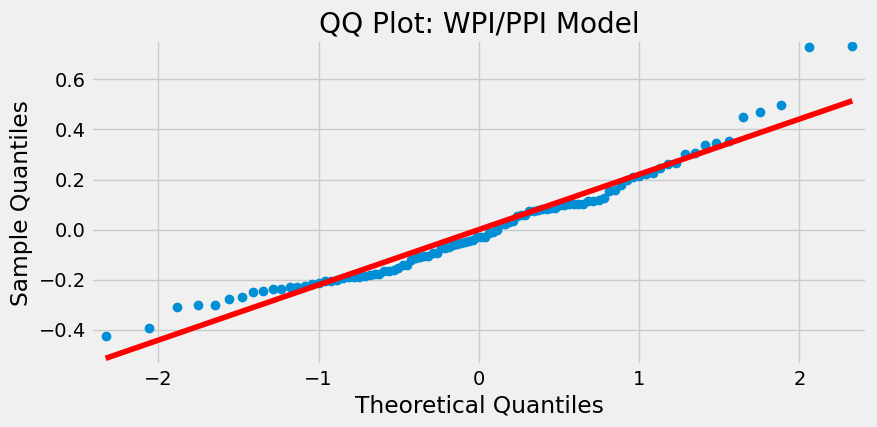

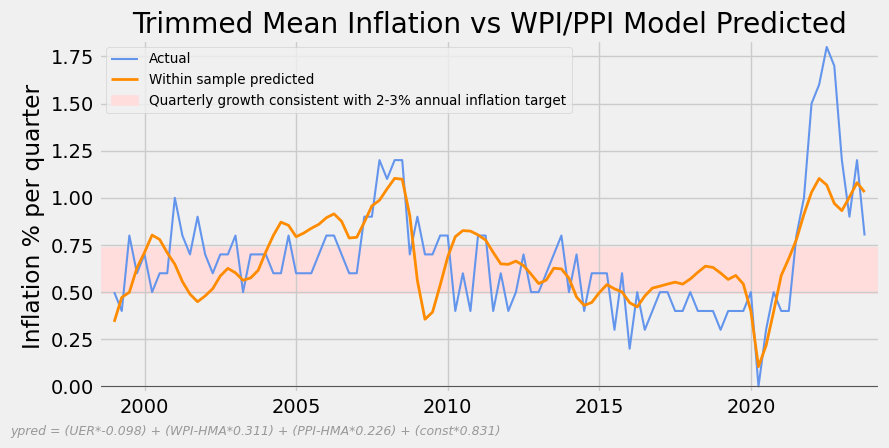

In [10]:
# Everything - quite a number of these coefficients not significantly different from zero
# Uktimately not a useful model
title = "Trimmed Mean Inflation vs WPI/PPI Model Predicted"
run_model(["UER", "WPI-HMA", "PPI-HMA", "const"], title, None)

                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     52.57
Date:                Sat, 04 May 2024   Prob (F-statistic):           3.44e-20
Time:                        13:40:23   Log-Likelihood:                 26.451
No. Observations:                 100   AIC:                            -44.90
Df Residuals:                      96   BIC:                            -34.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TM-1           0.4891      0.102      4.815      0.0

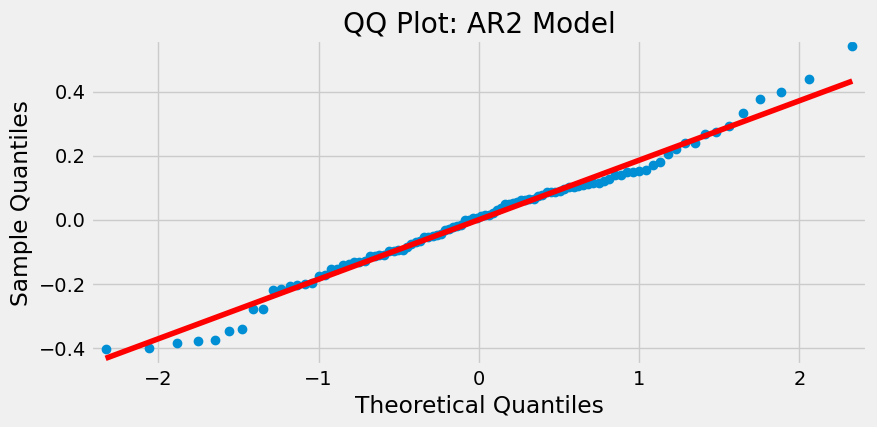

AttributeError: 'list' object has no attribute 'notna'

In [11]:
# REMOVE cooefficients that are not significantly different from zero
exog = ["TM-1", "TM-2", "UER", "const"]
title = "Trimmed Mean Inflation vs AR2 Model Predicted"
run_model(exog, title, endog)

In [ ]:
exog = ["TM-1", "UER", "const"]
title = "Trimmed Mean Inflation vs AR1 Model Predicted"
run_model(exog, title, endog)

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

In [ ]:
print("Finished")